In [1]:
# importing required libraries
from time import time
from tensorflow.keras.optimizers import Adam

from init import init_style_target
from init import init_generated_img

from vgg import create_list_of_vgg_layer
from vgg import load_vgg19
from vgg import create_multi_output_model

from image import load_image
from image import tensor_to_image

from verbose import display_pictures
from verbose import display_generated_img

from save import add_frame
from save import save_convertion

from loss import compute_style_loss
from compute import compute_and_optimize_gradient

from style import update_style

from tensorflow.keras.applications import VGG19
from keras import Model
from tensorflow import Tensor

from processing import preprocessing_img

from init import init_style_target

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow import Variable

from image import tensor_to_image

from IPython.display import clear_output, display

from tensorflow import GradientTape 
from keras import Model

from tensorflow.keras.optimizers import Optimizer

from processing import preprocessing_img
from vgg import get_features_map
from compute import compute_and_optimize_gradient

from compute import gram_matrix
from image import clip_pixel

In [2]:
def create_list_of_vgg_layer():

    style_layer_names   = ['block1_conv1',
                           'block2_conv1',
                           'block3_conv1',
                           'block4_conv1',
                           'block5_conv1']

    return (style_layer_names)

def load_vgg19()-> Model:
    vgg = VGG19(include_top=False, weights='imagenet')
    return vgg

def create_multi_output_model(style_layers : list)-> Model:

    vgg19 = load_vgg19()
    
    layers_name = style_layers
    layers_output = list()
    
    for name in layers_name:
        layer = vgg19.get_layer(name)
        output = layer.output
        layers_output.append(output)

    multi_output_model = Model([vgg19.input], layers_output)
    multi_output_model.trainable = False

    return (multi_output_model)

def get_features_map(model : Model, img : Tensor)->list:

        process_img = preprocessing_img(img)
        features_map = model(process_img)

        return (features_map)
    
def create_noisy_imag(img : Tensor):
    
    noise_filter = np.random.randn(*img.shape)
    return (noise_filter)


def create_batch_image(img : Tensor):

    img = tf.expand_dims(tf.constant(img),axis=0)
    return (img)


def init_generated_img(style_img : Tensor):

    
    generated_img = create_noisy_imag(style_img)
    generated_img = clip_pixel(generated_img)
    generated_img = create_batch_image(generated_img)
    generated_img = Variable(generated_img)

    return (generated_img)

In [3]:
def display_generated_img(generated_img : Variable):
    
    clear_output(wait=True)
    display(tensor_to_image(generated_img))

In [4]:
def extract_style(features_map):

    Grams_styles = list()
    
    for style in features_map:
        Gram = gram_matrix(style)
        Grams_styles.append(Gram)
    return Grams_styles

def compute_style_loss(style_generated : Tensor, 
                       style_target : Tensor):

    all_style_loss = list()

    for generated, target in zip(style_generated, style_target):

        style_layer_loss = tf.reduce_mean((generated - target)**2)
        all_style_loss.append(style_layer_loss)

    num_style_layers = len(all_style_loss)
    style_loss = tf.add_n(all_style_loss) / num_style_layers

    return (style_loss)

In [5]:
@tf.function
def update_style(model : Model,
                 style_target : Tensor, 
                 generated_img : Variable,
                 optimizer : Optimizer):

    with GradientTape() as tape :

        features_map = get_features_map(model, generated_img)
        style_generated = extract_style(features_map)
        
        loss = compute_style_loss(style_generated, style_target)

    generated_img = compute_and_optimize_gradient(tape,
                                                  optimizer, 
                                                  generated_img,
                                                  loss)

In [6]:
class Model_Style_Representation:

    def __init__(self, optimizer=Adam(learning_rate=0.02)):
        super().__init__()
    
        self.optimizer = optimizer
        
        self.style_layers = create_list_of_vgg_layer()
        self.num_style_layers  = len(self.style_layers)
        
        self.model = create_multi_output_model(self.style_layers)
        
        self.style_img = None
        self.generated_img = None
        
        self.frames = list()

    def import_img(self, style_img):

        self.style_img = load_image(style_img) 
        plt.imshow(self.style_img)

    
    def recreate_style(self, num_epochs,):

        target_style = init_style_target(self.model, self.style_img)
        self.generated_img = init_generated_img(self.style_img)
        
        # plt.imshow(tensor_to_image(self.generated_img))
        # display_generated_img(self.generated_img)
            
        start = time()
        for epoch in range(num_epochs) :

            update_style(self.model,
                         target_style, 
                         self.generated_img, 
                         self.optimizer)

            display_generated_img(self.generated_img) 
             
        end = time()
        print("Total training time: {:.1f} seconds".format(end-start))
        # save_convertion(self.frames, self.content_img, self.style_img, self.generated_img)
        return (self.generated_img)



In [7]:
Model = Model_Style_Representation()

2022-11-15 10:08:49.942891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 10:08:49.968311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 10:08:49.968561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 10:08:49.969132: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

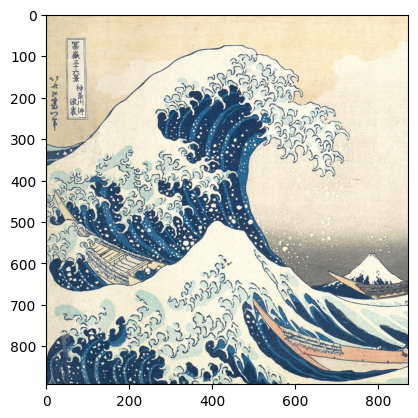

In [8]:
Model.import_img('img/style/waves.png')

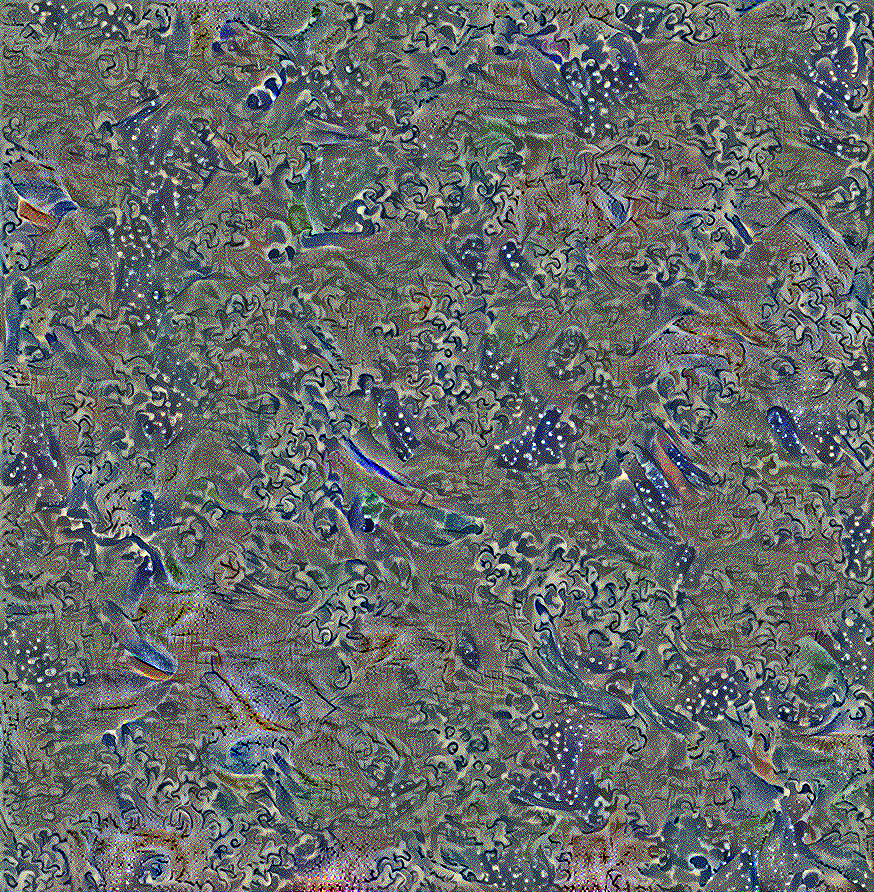

Total training time: 341.0 seconds


<tf.Variable 'Variable:0' shape=(1, 892, 874, 3) dtype=float64, numpy=
array([[[[0.0359884 , 0.8055225 , 0.73572451],
         [0.26608262, 0.71217086, 0.13270721],
         [0.21057477, 0.4703825 , 0.35319351],
         ...,
         [0.29121908, 0.29643698, 0.36485657],
         [0.26416645, 0.71924028, 0.55286219],
         [0.46661489, 0.53588169, 0.07705895]],

        [[0.05427291, 0.12187057, 0.81040776],
         [0.16180122, 0.9618817 , 0.19408275],
         [0.65056499, 0.17069208, 0.62998938],
         ...,
         [0.61846986, 0.18922561, 0.50847503],
         [0.14863289, 0.28207148, 0.42412   ],
         [0.41748352, 0.36867794, 0.31756912]],

        [[0.38318626, 0.77397686, 0.14718657],
         [0.87975816, 0.31288586, 0.26695752],
         [0.42737664, 0.32297626, 0.38754915],
         ...,
         [0.17862854, 0.39434474, 0.56137059],
         [0.605266  , 0.4463714 , 0.05913814],
         [0.14892103, 0.51688685, 0.50812855]],

        ...,

        [[0.15559708,

In [9]:
Model.recreate_style(1000)